## S10 - Assignment Objective:

* Write a customLinks to an external site. ResNet architecture for CIFAR10 that has the following architecture:

1. PrepLayer - Conv 3x3 s1, p1) >> BN >> RELU [64k]
2. Layer1 -
  * X = Conv 3x3 (s1, p1) >> MaxPool2D >> BN >> RELU [128k]
  * R1 = ResBlock( (Conv-BN-ReLU-Conv-BN-ReLU))(X) [128k]
  * Add(X, R1)
3. Layer 2 -
  * Conv 3x3 [256k]
  * MaxPooling2D
  * BN
  * ReLU
4. Layer 3 -
  * X = Conv 3x3 (s1, p1) >> MaxPool2D >> BN >> RELU [512k]
  * R2 = ResBlock( (Conv-BN-ReLU-Conv-BN-ReLU))(X) [512k]
  * Add(X, R2)
  * MaxPooling with Kernel Size 4
  * FC Layer
  * SoftMax
5. Uses One Cycle Policy such that:
  *  Total Epochs = 24
  *  Max at Epoch = 5
  *  LRMIN = FIND
  *  LRMAX = FIND
  *  NO Annihilation
6. Uses this transform
  * RandomCrop 32, 32 (after padding of 4)
  * FlipLR
  * Followed by CutOut(8, 8)
  * Batch size = 512
  * Use ADAM, and CrossEntropyLoss
  * Target Accuracy: 90%

7. NO score if your code is not modular. Your collab must be importing your GitHub package, and then just running the model. I should be able to find the custom_resnet.py model in your GitHub repo that you'd be training.
8. Once done, proceed to answer the Assignment-Solution page.

-----




In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
# Load modules/models from EVA course
!rm -rf models
!git clone https://github.com/PyarakaSrikanth/ERAV1_Utils -q --quiet
!mv ERAV1_Utils/* .
print("Loaded ERAV1 Modules and Models")
!rm -rf ERAV1_Utils

Loaded ERAV1 Modules and Models


In [2]:
## Installing Packages
!pip install torchsummary
!pip install albumentations
!pip install grad-cam
!pip install torch-lr-finder

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 27.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38247 sha256=b6b0d63a194bdbd61aac6bcbb460b027160cca9965772eea42d969d71cd330c7
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


Importing libraries

In [15]:
import torch
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from utils import *
from visualize import *
from main import *
from transformation import get_train_aug_transform,get_test_aug_transform

from models.custom_resnet import *
from torchsummary import summary

from torch.optim.lr_scheduler import StepLR
from torch_lr_finder import LRFinder
from torch.optim.lr_scheduler import OneCycleLR

import warnings
warnings.filterwarnings('ignore')

Loading data and Tranformations

In [4]:
trainloader = get_train_loader(transform=None)

100%|██████████| 170498071/170498071 [00:05<00:00, 29820884.77it/s]


Extracting /root/data/cifar10/cifar-10-python.tar.gz to /root/data/cifar10


In [5]:
## Calculating Mean and Std for Normalization
mean, std = get_stats(trainloader)

[Train]
 - Numpy Shape: (50000, 32, 32, 3)
 - Tensor Shape: (50000, 32, 32, 3)
 - min: 0
 - max: 255

Dataset Mean - [0.49139968 0.48215841 0.44653091]
Dataset Std - [0.24703223 0.24348513 0.26158784] 


In [7]:
## Function normalize and augment images
## Apply HorizontalFlip
## Randomcorp
## Cutout
## Flip
train_transform = get_train_aug_transform(mean, std)
test_transform = get_test_aug_transform(mean, std)

In [8]:
train_loader = get_train_loader(transform=train_transform)
test_loader = get_test_loader(transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']


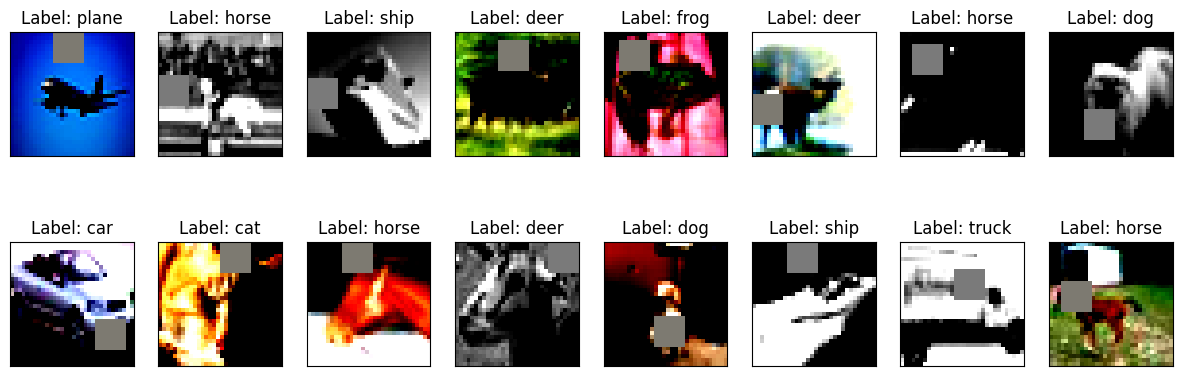

In [10]:
## After Augmentation printing samples
print_samples(train_loader,classes)

In [11]:
## Checking for CUDA and setting SEED
device = get_device()

CUDA Available? True


Transferring model to GPU and printing model summary

In [12]:

cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
model = CustomRes_Network().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
            Conv2d-4          [-1, 128, 32, 32]          73,856
         MaxPool2d-5          [-1, 128, 16, 16]               0
              ReLU-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
      BatchNorm2d-10          [-1, 128, 16, 16]             256
           Conv2d-11          [-1, 128, 16, 16]         147,584
             ReLU-12          [-1, 128, 16, 16]               0
      BatchNorm2d-13          [-1, 128, 16, 16]             256
           Conv2d-14          [-1, 256,

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.67E-03


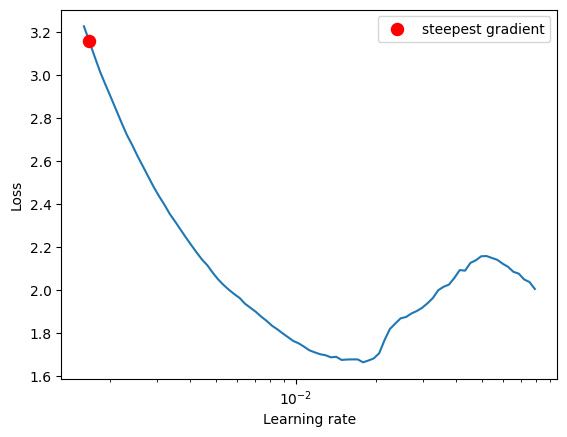

Min Loss = 1.6637662895834326, Max LR = 0.01788649529057435


In [14]:
model = CustomRes_Network()

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-7)
criterion = nn.CrossEntropyLoss()

# The model parameters are reset after this finishes
min_loss, max_lr = get_lr(
    model,
    train_loader,
    optimizer,
    criterion,
    device,
    end_lr=0.1,
    num_iter=100,
    step_mode="exp",
)

In [16]:

EPOCHS = 24

scheduler = OneCycleLR(
    optimizer,
    max_lr=max_lr,
    steps_per_epoch=len(train_loader),
    epochs=EPOCHS,
    pct_start=5 / EPOCHS,
    div_factor=100,
    three_phase=False,
    final_div_factor=100,
    anneal_strategy="linear",
)

trainer = Trainer(model, train_loader, optimizer, criterion, device)
tester = Tester(model, test_loader, criterion, device)

model, history = train_model(
    trainer, tester, NUM_EPOCHS=EPOCHS, scheduler=scheduler, save_best=False
)

EPOCH = 1 | LR = 0.003727633405035648 | Loss = 1.11 | Batch = 97 | Accuracy = 51.33: 100%|██████████| 98/98 [00:24<00:00,  4.01it/s]


Test set: Average loss: 0.0023, Accuracy: 6188/10000 (61.88%)



EPOCH = 2 | LR = 0.007276401857165553 | Loss = 0.75 | Batch = 97 | Accuracy = 67.91: 100%|██████████| 98/98 [00:22<00:00,  4.33it/s]


Test set: Average loss: 0.0015, Accuracy: 7495/10000 (74.95%)



EPOCH = 3 | LR = 0.010825170309295458 | Loss = 0.66 | Batch = 97 | Accuracy = 73.39: 100%|██████████| 98/98 [00:22<00:00,  4.44it/s]


Test set: Average loss: 0.0015, Accuracy: 7593/10000 (75.93%)



EPOCH = 4 | LR = 0.014373938761425361 | Loss = 0.53 | Batch = 97 | Accuracy = 76.50: 100%|██████████| 98/98 [00:22<00:00,  4.34it/s]


Test set: Average loss: 0.0012, Accuracy: 8006/10000 (80.06%)



EPOCH = 5 | LR = 0.017876890184966916 | Loss = 0.61 | Batch = 97 | Accuracy = 79.81: 100%|██████████| 98/98 [00:23<00:00,  4.22it/s]


Test set: Average loss: 0.0014, Accuracy: 7868/10000 (78.68%)



EPOCH = 6 | LR = 0.016935589835438216 | Loss = 0.64 | Batch = 97 | Accuracy = 83.54: 100%|██████████| 98/98 [00:22<00:00,  4.29it/s]


Test set: Average loss: 0.0013, Accuracy: 8022/10000 (80.22%)



EPOCH = 7 | LR = 0.015994289485909516 | Loss = 0.48 | Batch = 97 | Accuracy = 86.35: 100%|██████████| 98/98 [00:22<00:00,  4.39it/s]


Test set: Average loss: 0.0011, Accuracy: 8300/10000 (83.00%)



EPOCH = 8 | LR = 0.015052989136380817 | Loss = 0.33 | Batch = 97 | Accuracy = 88.87: 100%|██████████| 98/98 [00:22<00:00,  4.41it/s]


Test set: Average loss: 0.0010, Accuracy: 8449/10000 (84.49%)



EPOCH = 9 | LR = 0.014111688786852117 | Loss = 0.22 | Batch = 97 | Accuracy = 90.53: 100%|██████████| 98/98 [00:22<00:00,  4.35it/s]


Test set: Average loss: 0.0008, Accuracy: 8675/10000 (86.75%)



EPOCH = 10 | LR = 0.013170388437323417 | Loss = 0.19 | Batch = 97 | Accuracy = 91.62: 100%|██████████| 98/98 [00:22<00:00,  4.29it/s]


Test set: Average loss: 0.0010, Accuracy: 8550/10000 (85.50%)



EPOCH = 11 | LR = 0.012229088087794718 | Loss = 0.31 | Batch = 97 | Accuracy = 92.66: 100%|██████████| 98/98 [00:23<00:00,  4.15it/s]


Test set: Average loss: 0.0009, Accuracy: 8689/10000 (86.89%)



EPOCH = 12 | LR = 0.011287787738266018 | Loss = 0.15 | Batch = 97 | Accuracy = 94.12: 100%|██████████| 98/98 [00:22<00:00,  4.44it/s]


Test set: Average loss: 0.0009, Accuracy: 8721/10000 (87.21%)



EPOCH = 13 | LR = 0.010346487388737318 | Loss = 0.15 | Batch = 97 | Accuracy = 95.00: 100%|██████████| 98/98 [00:22<00:00,  4.31it/s]


Test set: Average loss: 0.0009, Accuracy: 8795/10000 (87.95%)



EPOCH = 14 | LR = 0.00940518703920862 | Loss = 0.12 | Batch = 97 | Accuracy = 95.63: 100%|██████████| 98/98 [00:22<00:00,  4.28it/s]


Test set: Average loss: 0.0008, Accuracy: 8878/10000 (88.78%)



EPOCH = 15 | LR = 0.00846388668967992 | Loss = 0.12 | Batch = 97 | Accuracy = 96.30: 100%|██████████| 98/98 [00:22<00:00,  4.34it/s]


Test set: Average loss: 0.0008, Accuracy: 8834/10000 (88.34%)



EPOCH = 16 | LR = 0.007522586340151221 | Loss = 0.06 | Batch = 97 | Accuracy = 96.89: 100%|██████████| 98/98 [00:23<00:00,  4.25it/s]


Test set: Average loss: 0.0008, Accuracy: 8843/10000 (88.43%)



EPOCH = 17 | LR = 0.006581285990622521 | Loss = 0.05 | Batch = 97 | Accuracy = 97.60: 100%|██████████| 98/98 [00:22<00:00,  4.43it/s]


Test set: Average loss: 0.0009, Accuracy: 8894/10000 (88.94%)



EPOCH = 18 | LR = 0.005639985641093819 | Loss = 0.06 | Batch = 97 | Accuracy = 97.97: 100%|██████████| 98/98 [00:23<00:00,  4.23it/s]


Test set: Average loss: 0.0009, Accuracy: 8877/10000 (88.77%)



EPOCH = 19 | LR = 0.00469868529156512 | Loss = 0.09 | Batch = 97 | Accuracy = 98.51: 100%|██████████| 98/98 [00:23<00:00,  4.23it/s]


Test set: Average loss: 0.0009, Accuracy: 8977/10000 (89.77%)



EPOCH = 20 | LR = 0.00375738494203642 | Loss = 0.03 | Batch = 97 | Accuracy = 98.83: 100%|██████████| 98/98 [00:22<00:00,  4.30it/s]


Test set: Average loss: 0.0009, Accuracy: 8977/10000 (89.77%)



EPOCH = 21 | LR = 0.0028160845925077217 | Loss = 0.02 | Batch = 97 | Accuracy = 99.16: 100%|██████████| 98/98 [00:22<00:00,  4.27it/s]


Test set: Average loss: 0.0009, Accuracy: 8995/10000 (89.95%)



EPOCH = 22 | LR = 0.0018747842429790197 | Loss = 0.01 | Batch = 97 | Accuracy = 99.29: 100%|██████████| 98/98 [00:23<00:00,  4.26it/s]


Test set: Average loss: 0.0008, Accuracy: 9007/10000 (90.07%)



EPOCH = 23 | LR = 0.000933483893450323 | Loss = 0.01 | Batch = 97 | Accuracy = 99.42: 100%|██████████| 98/98 [00:23<00:00,  4.21it/s]


Test set: Average loss: 0.0008, Accuracy: 9007/10000 (90.07%)



EPOCH = 24 | LR = -7.81645607837722e-06 | Loss = 0.02 | Batch = 97 | Accuracy = 99.56: 100%|██████████| 98/98 [00:23<00:00,  4.21it/s]


Test set: Average loss: 0.0008, Accuracy: 9031/10000 (90.31%)



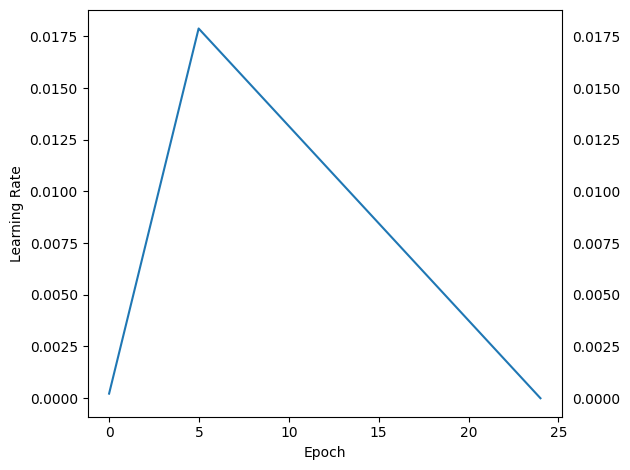

In [18]:

plot_lr_history(trainer,EPOCHS)

In [19]:
print(f"Max LR = {max(trainer.lr_history)}")
print(f"Min LR = {min(trainer.lr_history)}")

Max LR = 0.01788649529057435
Min LR = -7.81645607837722e-06


In [20]:
wrong_prediction_list = get_incorrect_predictions(model,test_loader,device)

Total Incorrect Predictions 969


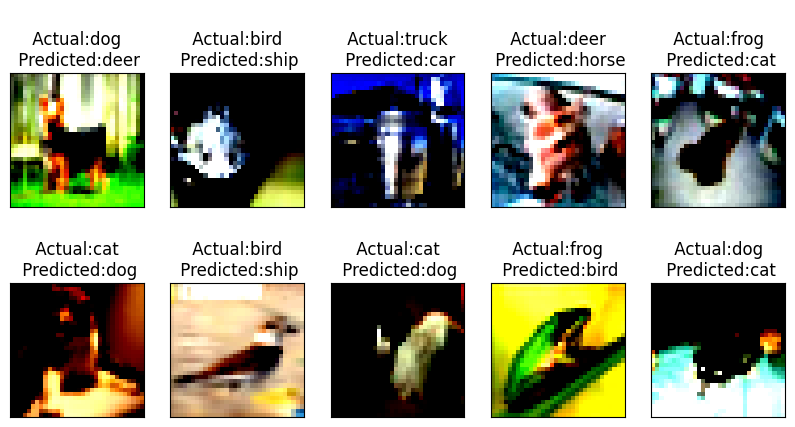

In [21]:
plot_incorrect_predictions(wrong_prediction_list,classes)

## Confusion Matrix

Confusion matrix, without normalization


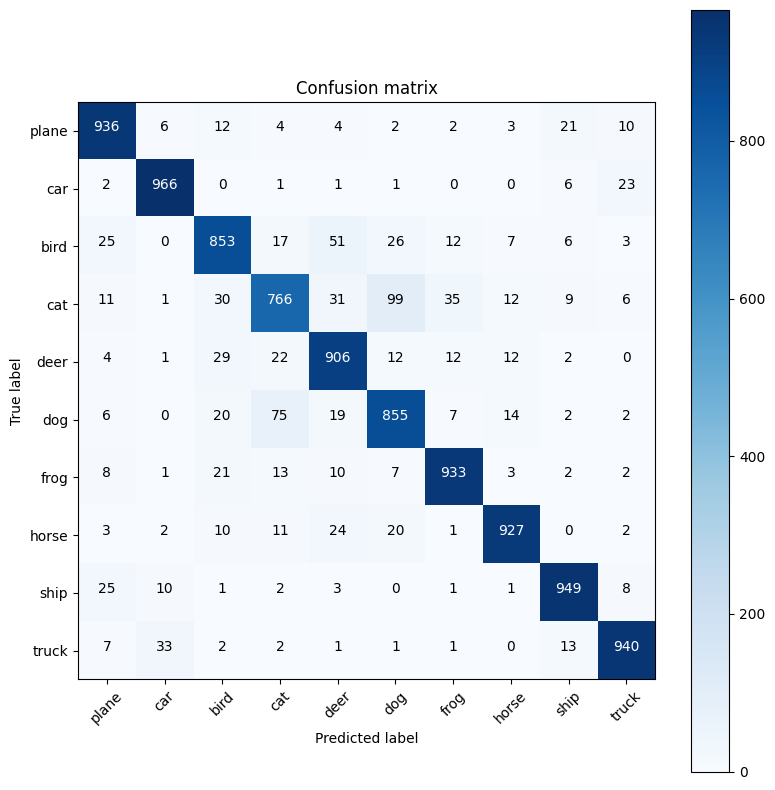

In [22]:
from utils import get_all_predictions, get_incorrect_predictions, prepare_confusion_matrix

all_preds, all_targets = get_all_predictions(model, test_loader, device)
confusion_matrix = prepare_confusion_matrix(all_preds, all_targets, classes)
plot_confusion_matrix(confusion_matrix, classes, False)

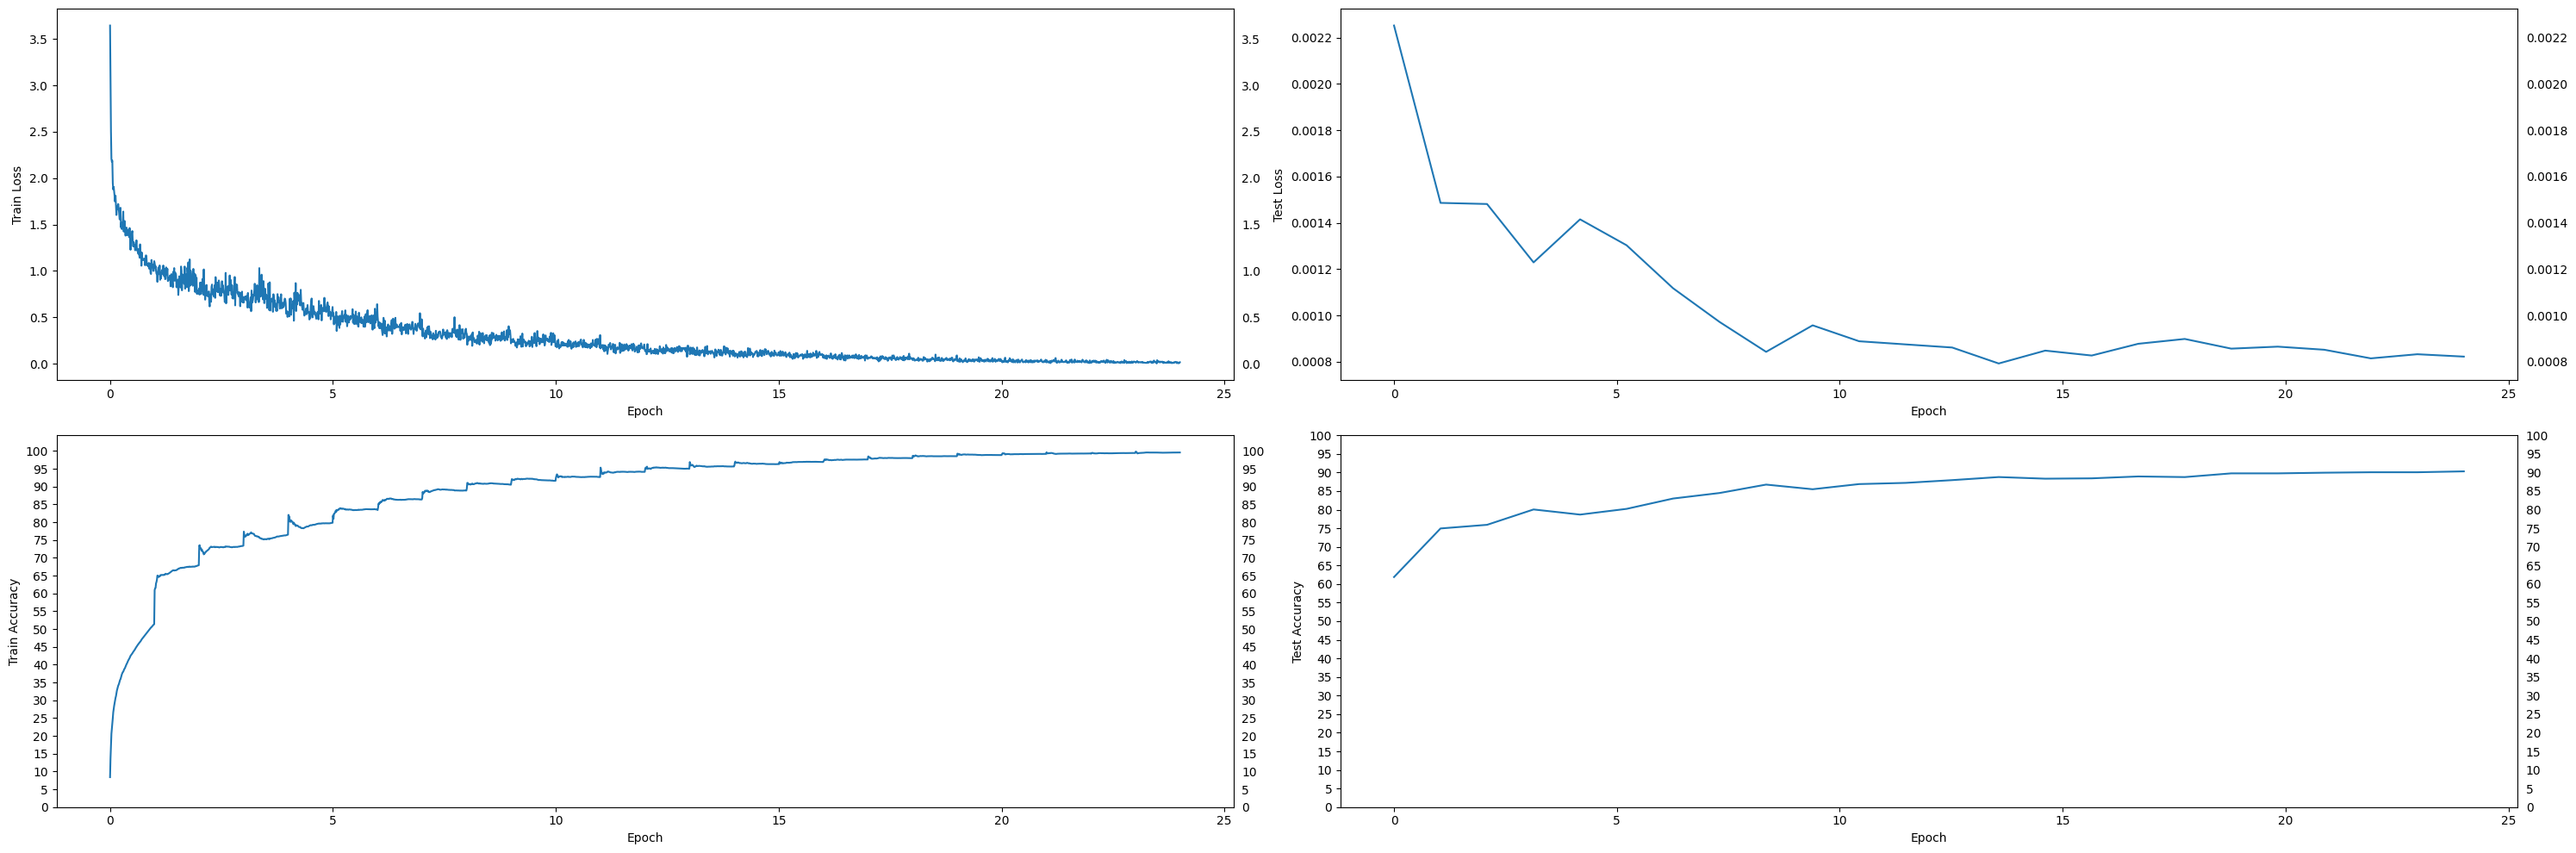

In [23]:
plot_losses_and_accuracies(trainer,tester,EPOCHS)

## Save Model

In [25]:
save_model(model,24,optimizer,"./model_artifact/model_s10.pth")

In [ ]:
# Load Model
#model.load_state_dict(torch.load('./model_artifact/model_s10.pth'))